## Approximate Nearest Neighbour using Annoy  
https://pypi.org/project/annoy/  
Based on code from   
https://www.kaggle.com/nicw102168/nearest-neighbor-classification-with-annoy

### Install Annoy
To install `annoy` use:  
`pip install annoy`  
If you have problems on a Mac make sure your XCode is up to date.

### Other Requirements
To run this notebook you will need to download the three data files and the `.py` file that loads the data:  
- `kNNDataLoader.py`
- `CC_default.csv`
- `HTRU_2.csv`
- `shuttle.csv`
- `letter-recognition.csv`  

You will also need `kNNAnnoy.py` - it contains code to wrap the annoy library in an sklearn-like object with `fit` and `predict` methods.  
These are all available in the git-hub repository.

In [3]:
!pip install annoy
import annoy
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from kNNAnnoy import kNNAnnoyClassifier
from sklearn.model_selection import train_test_split
import time
import statistics
from sklearn import metrics
import kNNDataLoader
import matplotlib.pyplot as plt

Load the four datasets.
Make sure you have downloaded the loader module (`kNNDataLoader.py`) and the four data files.

In [4]:
Name_arr, X_dir, y_dir = kNNDataLoader.data_loader()
Name_arr

['Credit', 'HTRU', 'Shuttle', 'Letter']

## kNNAnnoyClassifier

### Defaults
metric = 'euclidean'
n_trees = 10
n_neighbors = 5

In [5]:
from kNNAnnoy import kNNAnnoyClassifier

In [6]:
ANN = kNNAnnoyClassifier(n_neighbors = 5, n_trees = 10)
ts = time.time()
ds = 'Letter'
X_train, X_test, y_train, y_test = train_test_split(X_dir[ds], y_dir[ds],
                                                    random_state=0, test_size=1/2)

ANN = ANN.fit(X_train, y_train)
y_hat = ANN.predict(X_test)

tf = time.time()

In [7]:
acc = metrics.accuracy_score(y_test, y_hat)
conf = metrics.confusion_matrix(y_test, y_hat)

print("AnnonykNN Time: {0:.2f}".format(tf-ts))
print("Accuracy: {0:.2f}".format(acc))

AnnonykNN Time: 0.42
Accuracy: 0.92


## ANN Accuracy Evaluation
In this first test, we use a single tree in the ANN (`n_trees` = 1).

In [8]:
ANN = kNNAnnoyClassifier(n_neighbors = 5, n_trees = 1)
kNN = KNeighborsClassifier(n_neighbors=5)

m_names = ['k-NN','ANN']
models = {'k-NN':kNN, 'ANN':ANN}

In [9]:
ANN_acc = {}
ANN_t = {}

for m_name in models:
    m = models[m_name]
    print(m_name)
    times = {}
    accs = {}
    for ds in Name_arr:
        print(ds)
        X = X_dir[ds]
        y = y_dir[ds]

        t_start = time.time()
        X_train, X_test, y_train, y_test = train_test_split(X_dir[ds], y_dir[ds],
                                                    random_state=0, test_size=1/2)
        Model = m.fit(X_train, y_train)
        y_hat = Model.predict(X_test)

        t = time.time()-t_start
        acc = metrics.accuracy_score(y_test, y_hat)

        times[ds]= t
        accs[ds]= acc
        print(t)
    ANN_acc[m_name]=accs
    ANN_t[m_name]=times

k-NN
Credit
2.0088725090026855
HTRU
0.3642096519470215
Shuttle
7.352231740951538
Letter
0.9686267375946045
ANN
Credit
0.41739654541015625
HTRU
0.2930929660797119
Shuttle
0.5647635459899902
Letter
0.11023759841918945


In [10]:
resA_pd = pd.DataFrame(ANN_acc)
rest_pd = pd.DataFrame(ANN_t)

In [11]:
rest_pd

,k-NN,ANN
Credit,2.008873,0.417397
HTRU,0.364210,0.293093
Shuttle,7.352232,0.564764
Letter,0.968627,0.110238


In [12]:
resA_pd['Acc Percent']=resA_pd['ANN']/resA_pd['k-NN']*100
resA_pd['Time Percent']=rest_pd['ANN']/rest_pd['k-NN']*100
resA_pd

,k-NN,ANN,Acc Percent,Time Percent
Credit,0.789533,0.789733,100.025331,20.777652
HTRU,0.978769,0.977986,99.920082,80.473695
Shuttle,0.998115,0.997517,99.940109,7.681525
Letter,0.922900,0.769700,83.400152,11.380813


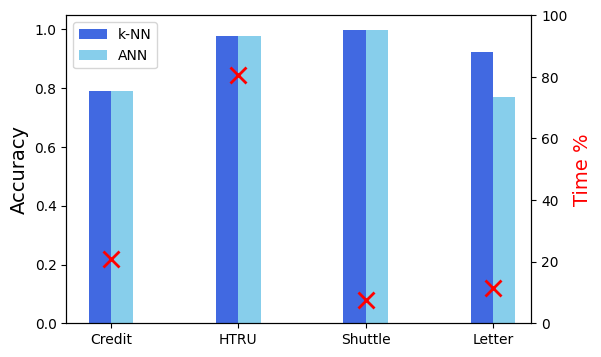

In [13]:
width = .35 # width of a bar

ax1=resA_pd[['k-NN','ANN']].plot(kind='bar', width = width,
                                 figsize=(6,4),
                                 color = ('royalblue','skyblue'))
ax2=resA_pd['Time Percent'].plot(secondary_y=True, color = 'r', markersize=12, mew =2,
                                 marker = 'x', linewidth = 0)

plt.xlim([-width, 4-2*width])
ax2.set_ylim(0,100)
ax1.set_ylabel('Accuracy',fontsize = 14)
ax2.set_ylabel('Time %', color = 'r', fontsize = 14)

plt.show()

## Accuracy v No of Trees
In the test above, there is no loss of accuracy with ANN, except in the `Letter` dataset.   
We now increase the number of trees to see if this accuracy can be recovered, and at what time cost.

In [14]:
TTrees = 10
nTrials = 5
ds = 'Letter'
X = X_dir[ds]
y = y_dir[ds]
X_train, X_test, y_train, y_test = train_test_split(X_dir[ds], y_dir[ds],
                                                    random_state=0, test_size=1/2)
times = []
accs = []

# Baseline figures for kNN
t_max = rest_pd['k-NN']['Letter']
a_max = resA_pd['k-NN']['Letter']

for nt in range(1, TTrees + 1):
    ANN = kNNAnnoyClassifier(n_neighbors = 5, n_trees = nt)
    tot = 0
    for tt in range(nTrials):
        t_start = time.time()
        Model = ANN.fit(X_train, y_train)
        y_hat = Model.predict(X_test)
        tot += (time.time()-t_start)
        acc = metrics.accuracy_score(y_test, y_hat)
    t_avg = tot/nTrials
    times.append(t_avg/t_max*100)
    accs.append(acc/a_max*100)


In [15]:
df = pd.DataFrame(list(zip(times, accs)), index = range(1,TTrees + 1),
              columns =['Time', 'Accuracy'])
df

,Time,Accuracy
1,10.658917,83.400152
2,13.155518,88.286922
3,14.645118,92.393542
4,16.229320,95.254090
5,18.466365,95.882544
6,21.059828,96.749377
7,22.956447,97.930437
8,27.269365,98.493878
9,46.990276,99.035648
10,34.670160,99.317369


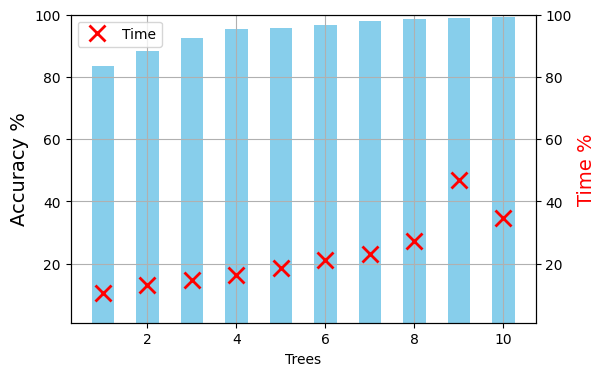

In [16]:
fig, ax1 = plt.subplots(figsize=(6,4))
r = range(1,11)
color = 'skyblue'
ax1.set_xlabel('Trees')
ax1.set_ylabel('Accuracy %', fontsize = 14 )
ax1.bar(r, df['Accuracy'], color=color, width = 0.5)
ax1.grid(which = 'major')
ax1.set_ylim(1,100)


ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'r'
ax2.set_ylabel('Time %',color = 'r', fontsize = 14 )  # we already handled the x-label with ax1
ax2.set_ylim(1,100)

ax2.plot(r, df['Time'], color=color, marker = 'x', markersize=12, mew =2,
                                  linewidth = 0,label='Time')
ax2.legend(loc = 'upper left')
plt.show()